In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.path as mpath
%matplotlib inline
from starkhelium import *
from tqdm import trange, tqdm
import os
import time

from scipy.constants import h, hbar, c, alpha, m_e, e, epsilon_0, atomic_mass, pi, physical_constants
a_0 = physical_constants['Bohr radius'][0]
E_h = physical_constants['Hartree energy'][0]
En_h = alpha**2.0 * m_e * c**2.0;
scl = c*10**-9 * En_h /(h * c);

# Calculate Stark map

In [2]:
# In an electric field (with B=0)
# quantum numbers
nmin = 4
nmax = 6
S = 1
n_vals, L_vals, m_vals = get_nlm_vals(nmin, nmax)
J_vals = get_J_vals(S, L_vals, 1)
# quantum defects
neff = n_vals - get_qd(S, n_vals, L_vals, J_vals)
# energy levels
En = W_n(S, n_vals, L_vals, J_vals)
# field-free Hamiltonian
H_0 = np.diag(En)
# find the off-diagonal terms of the Stark interaction matrix
mat_S = stark_matrix(n_vals, neff, L_vals, m_vals, field_orientation='crossed')

Calculating Stark terms: 100%|█████████████████| 77/77 [00:03<00:00, 22.39it/s]


In [13]:
# specify the electric field
field = np.linspace(0.00, 10**6, 501) # V /cm
field_au = field * 100 / (En_h_He/(e*a_0_He))
# specify the magnetic field (in Telsa)
B_z = 1.6154E-3
# (in atomic units)
B_z_au = B_z / (hbar/(e*a_0_He**2))
# Zeeman interaction Hamiltonian
H_Z = np.diag(E_zeeman(m_vals, B_z_au))
# diagonalise for each field
eig_vals, eig_vecs = stark_map(H_0, mat_S, field_au, H_Z=H_Z, returnEigVecs=True)

diagonalise Hamiltonian: 100%|██████████████| 501/501 [00:00<00:00, 889.83it/s]


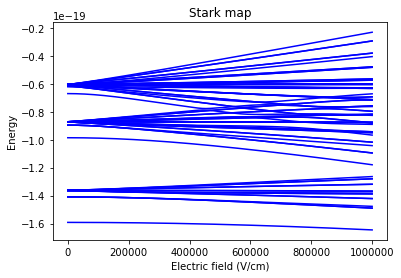

In [10]:
plt.plot(field, eig_vals*En_h, 'b')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy')
plt.title('Stark map')

# Transition dipole moments between two states

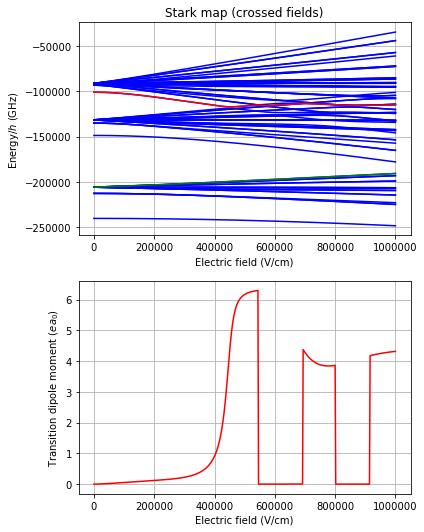

In [18]:
state_a = 4**2 + 5**2
state_b = 4**2 -1

tdm = []
for i, f in enumerate(field):
    weights = ( np.outer( eig_vecs[i,:,state_a], eig_vecs[i,:,state_b] ) )
    tdm.append( np.abs( np.sum( weights * mat_S ) ) )
    
plt.figure(figsize=(6,7.5))
plt.subplot(2,1,1)
plt.plot(field, eig_vals*scl, 'b')
plt.plot(field, eig_vals[:,state_a]*scl, 'r')
plt.plot(field, eig_vals[:,state_b]*scl, 'g')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/$h$ (GHz)')
plt.grid()
plt.title('Stark map (crossed fields)')

plt.subplot(2,1,2)
plt.plot(field, tdm, 'r', label='tdm')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Transition dipole moment ($ea_0$)')
plt.grid()

plt.tight_layout()

# State-character of another state

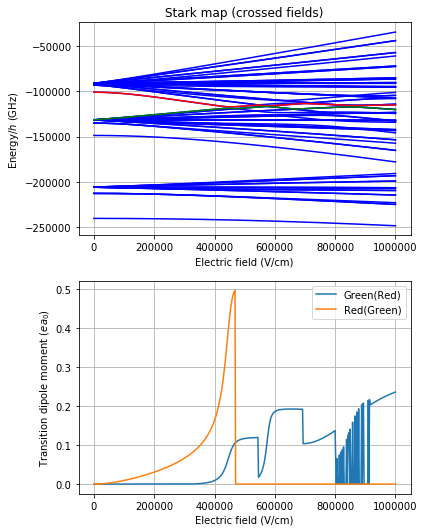

In [13]:
state_a = 4**2 + 5**2
state_b = 4**2 + 5**2 -1

l_char = []
for i, f in enumerate(field):
    l_char.append( [np.abs( eig_vecs[i,state_b,state_a] ),
                    np.abs( eig_vecs[i,state_a,state_b] )] )
    
plt.figure(figsize=(6,7.5))
plt.subplot(2,1,1)
plt.plot(field, eig_vals*scl, 'b')
plt.plot(field, eig_vals[:,state_a]*scl, 'r')
plt.plot(field, eig_vals[:,state_b]*scl, 'g')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/$h$ (GHz)')
plt.grid()
plt.title('Stark map (crossed fields)')

plt.subplot(2,1,2)
plt.plot(field, np.array(l_char)[:,0], label='Green(Red)')
plt.plot(field, np.array(l_char)[:,1], label='Red(Green)')
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Transition dipole moment ($ea_0$)')
plt.grid()
plt.legend()


plt.tight_layout()

# Plot tdm shaded Stark map

In [16]:
def colorline(
    x, y, z=None, cmap=plt.get_cmap('copper'), norm=plt.Normalize(0.0, 1.0),
        linewidth=3, alpha=1.0):
    """
    http://nbviewer.ipython.org/github/dpsanders/matplotlib-examples/blob/master/colorline.ipynb
    http://matplotlib.org/examples/pylab_examples/multicolored_line.html
    Plot a colored line with coordinates x and y
    Optionally specify colors in the array z
    Optionally specify a colormap, a norm function and a line width
    """

    # Default colors equally spaced on [0,1]:
    if z is None:
        z = np.linspace(0.0, 1.0, len(x))

    # Special case if a single number:
    if not hasattr(z, "__iter__"):  # to check for numerical input -- this is a hack
        z = np.array([z])
        
    z = np.asarray(z)

    segments = make_segments(x, y)
    lc = mcoll.LineCollection(segments, array=z, cmap=cmap, norm=norm,
                              linewidth=linewidth, alpha=alpha)

    return lc


def make_segments(x, y):
    """
    Create list of line segments from x and y coordinates, in the correct format
    for LineCollection: an array of the form numlines x (points per line) x 2 (x
    and y) array
    """

    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    return segments

def create_XY_array(x, y):
    path = mpath.Path(np.column_stack([x, y]))
    verts = path.interpolated(steps=1).vertices
    return verts[:, 0], verts[:, 1]

C:\Users\Alex\Anaconda3\lib\site-packages\ipykernel\__main__.py:14: RuntimeWarning: divide by zero encountered in log


tdm max =  3.40641473652


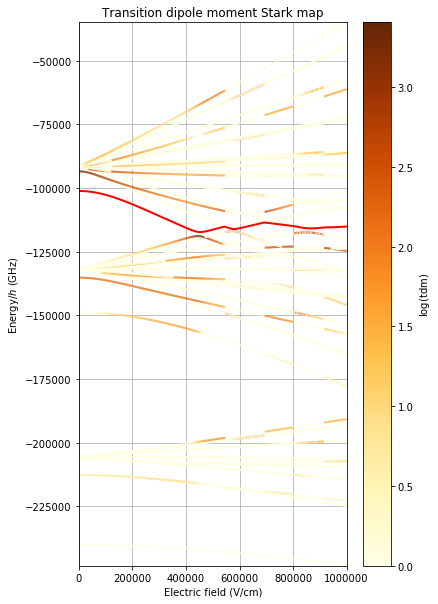

In [26]:
state_i = 4**2 + 5**2

plt.figure(figsize=(6,10))
ax = plt.gca()
max_z = 0

for state_f in range(len(eig_vals[0])):
    if not(state_i == state_f):
        tdm = []
        for i, f in enumerate(field):
            weights = ( np.outer( eig_vecs[i,:,state_i], eig_vecs[i,:,state_f] ) )
            tdm.append( np.abs( np.sum( weights * mat_S ) ) )
        x, y = create_XY_array(field, eig_vals[:,state_f]*scl)
        z = np.log(tdm)
        max_z = np.max([max_z, np.max(z)])
        ax.add_collection( colorline(x, y, z, cmap=plt.get_cmap('YlOrBr'), linewidth=2, norm=plt.Normalize(0.0, 3.406)) )

plt.plot(field, eig_vals[:,state_i]*scl, 'r', lw=2)
        
plt.xlim([np.min(field),np.max(field)])
plt.ylim([np.min(eig_vals)*scl,np.max(eig_vals)*scl])
plt.xlabel('Electric field (V/cm)')
plt.ylabel('Energy/$h$ (GHz)')
plt.title('Transition dipole moment Stark map')
plt.grid()

fig = plt.gcf()
z = np.linspace(0,max_z,len(field))
lc = colorline(x, y, z, cmap=plt.get_cmap('YlOrBr'), linewidth=2, norm=None) 
axcb = fig.colorbar(lc)
axcb.set_label('$\log$(tdm)')
ax.collections[0]
        
print('tdm max = ', max_z)

# Unused functions

In [87]:
def get_sorted_nlm_vals(nmin, nmax):
    """ n, l and m vals for each matrix column, using range n_min to n_max.
        The returned order is in order of increasing energy
    """
    n_rng = np.arange(nmin, nmax + 1)
    n_vals = np.array([], dtype='int32')
    l_vals = np.array([], dtype='int32')
    m_vals = np.array([], dtype='int32')
    for n in n_rng:
        l_rng = np.arange(0, n)
        for l in l_rng:
            m_rng = np.array( [[-i,i] for i in np.arange(l,0,-1)], dtype='int32' ).reshape(-1)
            m_rng = np.append(m_rng, 0)
            n_vals = np.append(n_vals, np.array(np.zeros_like(m_rng) + n))
            l_vals = np.append(l_vals, np.array(np.zeros_like(m_rng) + l))
            m_vals = np.append(m_vals, m_rng)
    return n_vals, l_vals, m_vals

def reorder_indicies(n_vals_1, L_vals_1, m_vals_1, n_vals_2, L_vals_2, m_vals_2):
    indicies = np.array([], dtype='int32')
    for i in range(len(n_vals_1)):
        for j in range(len(n_vals_2)):
            if n_vals_1[i] == n_vals_2[j] and L_vals_1[i] == L_vals_2[j] and m_vals_1[i] == m_vals_2[j]:
                indicies = np.append(indicies, j)   
                break
    return indicies